<a href="https://colab.research.google.com/github/SergioJF10/MLT-ESI-UCLM_CIS/blob/main/products/Notebooks/Models/TF_IDF_POS_and_Extra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-IDF Vectorization, POS Tagging and Extra Features
In this colab, we will develop the fourth and final approach, including the TF-IDF vectorization, with POS tagging and two extra features:
1. Number of words in an opinion.
2. Number of sentences in an opinion.

Again, we want to highlight that we did not include the N-grams due to its high memory demanding aspect.

In [ ]:
%%capture
!pip install nltk
import nltk
nltk.download("popular")
import json
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/products.csv' 'products.csv'
!cp '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/x_train.json' 'x_train.json'
!cp '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/y_train.json' 'y_train.json'
!cp '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/x_test.json' 'x_test.json'
!cp '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/y_test.json' 'y_test.json'

Mounted at /content/gdrive
cp: cannot stat '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/products.csv': No such file or directory
cp: cannot stat '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/x_train.json': No such file or directory
cp: cannot stat '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/y_train.json': No such file or directory
cp: cannot stat '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/x_test.json': No such file or directory
cp: cannot stat '/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Tecniques/Natural Language Processing/y_test.json': No such file or directory


# 0. Loading the Data
From the Preprocessing notebook, we obtain the following files with the data ready to be vectorized.
- x_train.json
- x_test.json
- y_train.json
- y_test.json
- word_count.json
- sents_count.json

_Note: Please upload those six files. They can be found in the "Data/Interim" folder in the `products` project folder._

In [ ]:
x_train = []
x_test = []
y_train = []
y_test = []
word_count = []
sents_count = []
with open('x_train.json', 'r', encoding='utf-8') as x_train_file:
  x_train = json.load(x_train_file)
with open('x_test.json', 'r', encoding='utf-8') as x_test_file:
  x_test = json.load(x_test_file)
with open('y_train.json', 'r', encoding='utf-8') as y_train_file:
  y_train = json.load(y_train_file)
with open('y_test.json', 'r', encoding='utf-8') as y_test_file:
  y_test = json.load(y_test_file)
with open('word_count.json', 'r', encoding='utf-8') as word_file:
  word_count = json.load(word_file)
with open('sents_count.json', 'r', encoding='utf-8') as sent_file:
  sent_count = json.load(sent_file)

Once the file descriptors have been used, we will delete them to save RAM.

In [ ]:
del x_test_file
del x_train_file
del y_test_file
del y_train_file
del word_file
del sent_file

Another step is to split correctly the word and sentence count arrays. If we remember, in the NLP [preprocessing colab](https://colab.research.google.com/github/SergioJF10/MLT-ESI-UCLM_CIS/blob/main/products/Notebooks/NLP/NLP_products.ipynb#scrollTo=WnzTadlOEGas) we used the [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with `shuffle = False`, which means that the data will be returned in the same order as input but splitted.

So now, we can just split the arrays with the code above and we have obtained the train and test arrays in the correct order to be matched with X data.

In [ ]:
word_train = word_count[:len(x_train)]
word_test = word_count[len(x_train):]

sent_train = sent_count[:len(x_train)]
sent_test = sent_count[len(x_train):]

# 1. TF-IDF Vectorization, POS Tagging and Extra Features
Let's now apply vectorization techniques over the preprocessed data in order to prepare the input for the models.

We apply the TFIDF vectorization over both, the train and the test sets according to the vocabulary from all the documents.

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
vectorizer.fit(x_train + x_test)
x_train_tfidf = vectorizer.transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

Once we have obtained the TFIDF vectorization, we have to get rid of a 70% of the total features, so, we need the best 30% of the whole list of features, let's call it $k$.

In [ ]:
k = int(0.3*x_train_tfidf.shape[1])
print(k)

15542


Let's now select the most important features for bot train and test sets.

In [ ]:
selector = SelectKBest(score_func=chi2, k=k)
x_train_tfidf = selector.fit_transform(x_train_tfidf, y_train)
x_test_tfidf = selector.transform(x_test_tfidf)
print(x_train_tfidf.shape[1])

15542


Before continouing with the process, we will delete both, the selector and the vectorizer objects in order to save the maximum amount of RAM possible.

In [ ]:
del selector
del vectorizer

We should highlight that, originally, the different results should be stored in different variables but, due to the huge memory consumed per each variable, we will use just one variable.

Now, we store both of them in a pandas dataframe to apply the pertinent transformations.

In [ ]:
x_train_tfidf = pd.DataFrame(data=x_train_tfidf.toarray())
x_test_tfidf = pd.DataFrame(data=x_test_tfidf.toarray())

Wow, let's try to add some information from the **POS tagging**. In our case, the most appropriate would be the number of adjectives, since, the more adjectives in a review, the more information about the product it has.

Please note that the process for both, the train and test data might take a while.

In [ ]:
pos_array = []

def n_adjs(pos_tags):
  number = 0
  for tag in pos_tags:
    if tag[1] == 'JJ': # Adjectives
      number += 1
  return number

for voc in tqdm(x_train):
  pos_tags = nltk.pos_tag(voc.split(' '))
  pos_array.append(n_adjs(pos_tags))

100%|██████████| 35414/35414 [01:36<00:00, 366.84it/s]


In [ ]:
pos_test = []
for voc in tqdm(x_test):
  pos_tags = nltk.pos_tag(voc.split(' '))
  pos_test.append(n_adjs(pos_tags))

100%|██████████| 15178/15178 [00:41<00:00, 363.28it/s]


Now we simply add the new values to the dataframes.

In [ ]:
x_train_tfidf['n_adjs'] = pos_array
x_test_tfidf['n_adjs'] = pos_test

In [ ]:
x_train_tfidf['n_words'] = word_train
x_test_tfidf['n_words'] = word_test

In [ ]:
x_train_tfidf['n_sentences'] = sent_train
x_test_tfidf['n_sentences'] = sent_test

Once the data has been added to both DataFrames, we can delete variables `pos_array` and `pos_test`, `word_train` and `word_test` and `sent_train` and `sent_test`. Same happens with arrays `pos_tags`, `x_train` and `x_test`.

In [ ]:
del word_train
del word_test
del sent_train
del sent_test
del pos_array
del pos_test
del x_train
del x_test
del pos_tags

### Undersampling
_Note: In a normal Google Colab session, we cannot execute both, pos tagging + tf-idf with undersampling. This might make the results a bit worse._

_For executing the undersampling, just mark the checkbox and run the below cells_.

In [ ]:
exec_undersampling = False #@param {type:"boolean"}

-----

Let's now try to apply an undersampling technique to compensate the labels.

In [ ]:
if exec_undersampling: 
  # ram option selected
  x_train_tfidf['label'] = y_train

  n = int(22111 * 0.3) # undersampling rate
  msk = x_train_tfidf.groupby('label')['label'].transform('size') >= n
  x_train_tfidf = pd.concat((x_train_tfidf[msk].groupby('label').sample(n=n), x_train_tfidf[~msk]), ignore_index=True)
  print(x_train_tfidf['label'].value_counts())

Once the mask have been used, we can delete it to save RAM usage.

We will also remove the x_train and x_test variables, since they have been properly loaded and vectorized, so we can erase them.

Due to a similar reason, we can remove also the x_train_tfidf variable.

In [ ]:
if exec_undersampling:
  # ram option selected
  del msk
  del x_train
  del x_test

### Naive Bayes
Now, it's time to train our first model, a Naive Bayes model with a Multinomial approach, since it is the most appropriate for our case.

In [ ]:
if exec_undersampling:
  # ram option selected
  mngb_model = MultinomialNB().fit(x_train_tfidf.drop('label', axis=1), x_train_tfidf['label'])
else:
  mngb_model = MultinomialNB().fit(x_train_tfidf, y_train)
preds = mngb_model.predict(x_test_tfidf)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


It is important to remember the considerable imbalance observed in the data. Due to this reason, we will use f1 score instead of the accuracy for evaluating the model.

Accuracy for the model: 0.6182632757939123


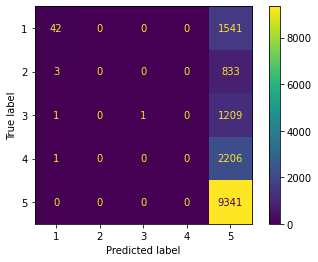

In [ ]:
print(f'Accuracy for the model: {f1_score(y_test, preds, average="micro")}')
cm = confusion_matrix(y_test, list(preds), labels=mngb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mngb_model.classes_) 
disp.plot()
plt.show()

### Decision Tree
_**NOTE**: In a normal Google Colab session, we ran out of memory when training the decision tree. For this reason, we cannot execute it with a conventional account. Anyway, we leave the code here._

_We have executed it (combined with the undersampling) locally in our machines to check the results and it gets an accuracy of $0.4754$ according to the F1 score used._

----

As we are asked to apply two models, the second one will be a decision tree. For this model, we will also try to optimize the hyperparametrization aiming to improve the accuracy.

In [ ]:
if exec_undersampling:
  # ram option selected
  dt_model = DecisionTreeClassifier(min_samples_leaf=1, max_depth=8, criterion='entropy')
  dt_model.fit(x_train_tfidf.drop('label', axis=1), x_train_tfidf['label'])
else:
  dt_model = DecisionTreeClassifier(min_samples_leaf=1, max_depth=8, criterion='entropy')
  dt_model.fit(x_train_tfidf, y_train)
preds = dt_model.predict(x_test_tfidf)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Now, the same as with Naive Bayes classifier, we will check the confusion matrix as well as the f1 score.

In [ ]:
print(f'Accuracy for the model: {f1_score(y_test, preds, average="micro")}')
cm = confusion_matrix(y_test, list(preds), labels=mngb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mngb_model.classes_) 
disp.plot()
plt.show()

### Voting Classifier
_**NOTE**: Again, due to the lack of RAM memory in an standard Google Colab account, we couldn't execute this in the notebook. We tested it in our own machines with a Python script._

_Locally, we got a $0.4738$ of accuracy with the F1 Score metric when applying the Voting classifier with undersampled data._

_Anyway, we indicate here the code for further possible executions with better accounts._

----

Aiming to improve the accuracy, we will try to apply an ensemling model, specifically a Voting Classifier.

First, we add a new model based on K Nearest Neighbors to complete the ensembler model.

In [ ]:
# kNN
knn_model = KNeighborsClassifier(n_neighbors=16, weights='uniform', metric='minkowski', p=1)

Now we build the Voting Classifier model, using the models we have previously used.

In [ ]:
voting_model = VotingClassifier(estimators=[('mnb', mngb_model), ('dt', dt_model)], voting='soft')
voting_model.fit(x_train_tfidf.drop('label', axis=1), x_train_tfidf['label'])
preds = voting_model.predict(x_test_tfidf)

Let's check the confusion matrix and its accuracy as we did with the previous models.

In [ ]:
print(f'Accuracy for the model: {f1_score(y_test, preds, average="micro")}')
cm = confusion_matrix(y_test, list(preds), labels=mngb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mngb_model.classes_) 
disp.plot()
plt.show()